<a href="https://colab.research.google.com/github/adam-mehdi/MuarAugment/blob/master/MuAugmentTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuAugment in a Classification Task

**Welcome! In this tutorial, we apply the `MuAugment` algorithm to a simple classification task.**

The `MuAugment`-specific code all lies in section 3: 'Define the Model', so jump straight to that if you are familiar with the PyTorch Lightning flow. If not, enjoy the harrowing ride! ☜(ﾟヮﾟ☜)

## 1. Imports

We are going to use PyTorch Lightning Flash for a quick baseline on which we will apply `MuarAugment`.

In [ ]:
%%capture
!pip install git+https://github.com/adam-mehdi/MuarAugment.git
!pip install pytorch-lightning
!pip install lightning-flash
!pip install timm
!pip install neptune-client

In [ ]:
import numpy as np
from typing import Union
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import timm

import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
from flash.core.data.utils import download_data
from flash.image import ImageClassificationData

import muar
from muar.utils import tensor2pil
from muar.augmentations import BatchRandAugment, MuAugment

/usr/local/lib/python3.7/dist-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


Kornia raises some unneeded deprecation flags. No need to mind those.

## 2. Download and load data

We're going to download and load the hymenoptera data from lightning flash. For new datasets, you can instead contruct a datamodule or massage the data into a couple dataloaders, as the standard PyTorch Lightning flow goes.

For the hymenoptera dataset, we to predict whether an image portrays a bee or an ant. In essence, an ugly cats-versus-dogs classification task.

In [ ]:
download_data("https://pl-flash-data.s3.amazonaws.com/hymenoptera_data.zip", 'data/')

datamodule = ImageClassificationData.from_folders(
    train_folder="data/hymenoptera_data/train/",
    val_folder="data/hymenoptera_data/val/")

# datamodule.batch_size = 64

`MuAugment` needs the ballpark mean and std of our images to denormalize and normalize them properly. We can find those on a batch of data.

In [ ]:
batch = next(iter(datamodule.train_dataloader()))
mean,std = batch['input'].mean((0,2,3)), batch['input'].std((0,2,3))

batch['input'].shape, batch['target'].shape

(torch.Size([4, 3, 196, 196]), torch.Size([4]))

The images that MuAugment consumes must be normalized in the range [0,1]. Let's check that.

In [ ]:
batch['input'].min(),batch['input'].max()

(tensor(0.), tensor(1.))

## 3. Define the model

This is where `MuAugment` requires special code. Fortunatly, it's as easy as supplying extra arguments to the `LightningModule`.

 ```python
 class LitModule(pl.LightningModule):
     def __init__(self, n_tfms, magn, mean, std, n_compositions, n_selected):
        ...
        rand_augment = BatchRandAugment(n_tfms, magn, mean, std)
        self.mu_transform = MuAugment(rand_augment, n_compositions, n_selected)

    def training_step(self, batch, batch_idx):
        self.mu_transform.setup(self)
        input, target = self.mu_transform((batch['input'], batch['target']))
        ...
```

In pure PyTorch, you can do the same in the function containing the training logic:

```python
def train_fn():
    rand_augment = BatchRandAugment(n_tfms, magn, mean, std)
    mu_transform = MuAugment(rand_augment, n_compositions, n_selected)
    for epoch in range(N_EPOCHS):
        for i,batch in enumerate(train_dataloader):
            mu_transform.setup(model)
            input, target = self.mu_transform(batch)
```

**Essential Arguments**

For most cases, MuAugment requires six arguments.

---
Four as input to `BatchRandAugment`:
- `n_tfms` *(int)*: Number of transformations sampled for each composition, excluding resize or label mixing transforms.
- `magn` *(int)*: Magnitude of augmentation applied. Ranges from [0, 10] with 10 being the max magnitude.
- `mean` *(tuple, torch.Tensor)*: Mean of images after normalized in range [0,1]
- `std` *(tuple, torch.Tensor)*: Mean of images after normalized in range [0,1]

And, in addition to `BatchRandAugment`, `MuAugment` consumes:
- `n_comps` (int): Number of compositions placed on each image.
- `n_selected` (int): Number of selected compositions for each image.
---

**Special Arguments**

We can supply `BatchRandAugment` other optional arguments if we wish to apply batch-wise resize transforms, MixUp or custom transforms.

---
- For batch-wise resizing, supply `use_resize` to specify what resizing method to use and `image_size` containing a final image size in the form `(height, width)`.

- For MixUp, supply `use_mix` and `mix_p`, the probability of applying MixUp on any given batch. Make sure to use the `MixUpCrossEntropyLoss` class in `muar.loss` as the criterion instead of the standard `nn.CrossEntropyLoss`. Other label-mixing transforms like CutMix are to be added later.

- If yours is a sensitive dataset (like one of medical images) whose information would be distorted by standard augmentations, a custom list of transforms may be necessary. Supply `transform_list`, a list of `Kornia` transforms with specified magnitude. See `muar.transform_lists` for the default lists of transforms; it might help to begin cobbling together your custom transform list using the default as a template. By the way, `Kornia` is an image augmentation library just like albumentations except that its transforms support batch-wise transformations on the GPU.

---

MuAugment works as follows.

Let's suppose the following hyperparameters:
- `N_TFMS = 3`
- `MAGN = 4`
- `N_COMPOSITIONS = 4`
- `N_SELECTED = 2`

`BatchRandAugment` outputs `4` different compositions, each contining of `3` transforms of magnitude `4`. The compositions are chosen uniformly at random from a list of transforms. Here is a simplified version of the code for choosing compositions:

```python
import numpy as np
import albumentations as 

def rand_augment(N_TFMS, MAGN):
    # initialize the transform list
    transforms = [A.HorizontalFlip(p=1), 
                  A.Rotate(MAGN*9, p=1),  
                  A.RandomBrightness(MAGN/20, p=1)]
    # randomly choose `N_TFMS` transforms from the list
    composition = np.random.choice(transforms, N_TFMS, replacement=False)   
    return A.Compose(composition)
```
`MuAugment` applies each of those `4` different compositions on the batch, so for each image, we have `4` corresponding augmented versions. We feed each of those augmented version into our model and compute the loss. We keep the `2` augmented images with the *highest loss* for training and discard the rest. Return a batch of size `batch_size`*`2` of our selected augmented images with their corresponding targets.


In [ ]:
# Backbone for transfer learning.
class CustomResNet(pl.LightningModule):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        return x

# We implement MuAugment inside of the LightningModule.
class LitModule(pl.LightningModule):
    def __init__(self, 
                 n_tfms: int = 3, 
                 magn: int = 3,
                 mean: Union[tuple, torch.Tensor] = mean, 
                 std: Union[tuple, torch.Tensor] = std, 
                 n_compositions: int = 4, 
                 n_selected: int = 2,
                 model_name: str = 'resnet18',
                 pretrained: bool = cfg.pretrained,
                 num_classes: int = 2,
                 lr: float = 3e-3
                 ):
        
        super().__init__()
        self.save_hyperparameters()

        self.model = CustomResNet(model_name=model_name, pretrained=pretrained)
        self.model.freeze()
        
        self.fc = nn.Linear(self.model.in_features, num_classes)
        self.metric = pl.metrics.F1(num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        
        rand_augment = BatchRandAugment(n_tfms, magn, mean, std)
        self.mu_transform = MuAugment(rand_augment, n_compositions, n_selected)

    def forward(self, x):
        x = self.model(x)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        self.mu_transform.setup(self)
        input,target = self.mu_transform((batch['input'],batch['target']))

        if self.current_epoch == 2: self.model.unfreeze()
        output = self(input)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)

        return loss

    def validation_step(self, batch, batch_idx):
        input,target = batch['input'],batch['target']

        output = self(input)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)

        logger.experiment.log_metric('valid_loss', loss)
        logger.experiment.log_metric('valid_f1', score)
        return loss
    
    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return self.optimizer

## 4. Training

Configuration classes are useful for organizing all hyperparameters in the same place.

In [ ]:
class cfg:
    model_name = 'resnet18'
    lr = 3e-3
    pretrained = True
    num_classes = 2
    num_epochs = 20
    precision = 16
    n_tfms = 3
    magn = 3
    n_compositions = 4
    n_selected = 2
    mean = mean
    std = std

In [ ]:
model = LitModule(cfg.n_tfms, cfg.magn, cfg.mean, cfg.std, cfg.n_compositions, cfg.n_selected)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/__init__.py:14: DeprecationWarning: Argument `multilabel` was deprecated in v0.3 and will be removed in v0.4. Use `multiclass` instead.
  DeprecationWarning


For the augmentations to work, we must use full precision in training.

In [ ]:
trainer = pl.Trainer(
    max_epochs=cfg.num_epochs,
    gpus=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/adam-mehdi/misc-experiments/e/CIF-122



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | CustomResNet     | 11.2 M
1 | fc        | Linear           | 1.0 K 
2 | metric    | F1               | 0     
3 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


In [ ]:
# save model
trainer.save_checkpoint("image_classification_model.pt")

**How can we get better results from MuAugment?** Two main ways:

- Tune `MAGN` in a grid search to find the optimal amount of augmentation for the dataset and model.
- Increasing the difference between `N_COMPOSITIONS` and `N_SELECTED` yields a [higher accuracy](https://arxiv.org/abs/2005.00695) at the cost of more training time.

*One tip for regularizing*: larger datasets and models generally [require more regularization](https://arxiv.org/abs/1909.13719). Larger datasets have more signal-to-noise ratio, so it takes more regualization to reach the optimal ratio. Larger models are more powerful in finding patterns, making them them more prone to overfit, so they require more regulaization. 

## 5. Inspecting Images and Performance

Here's what some of the augmented images produced by MuAugment look like:
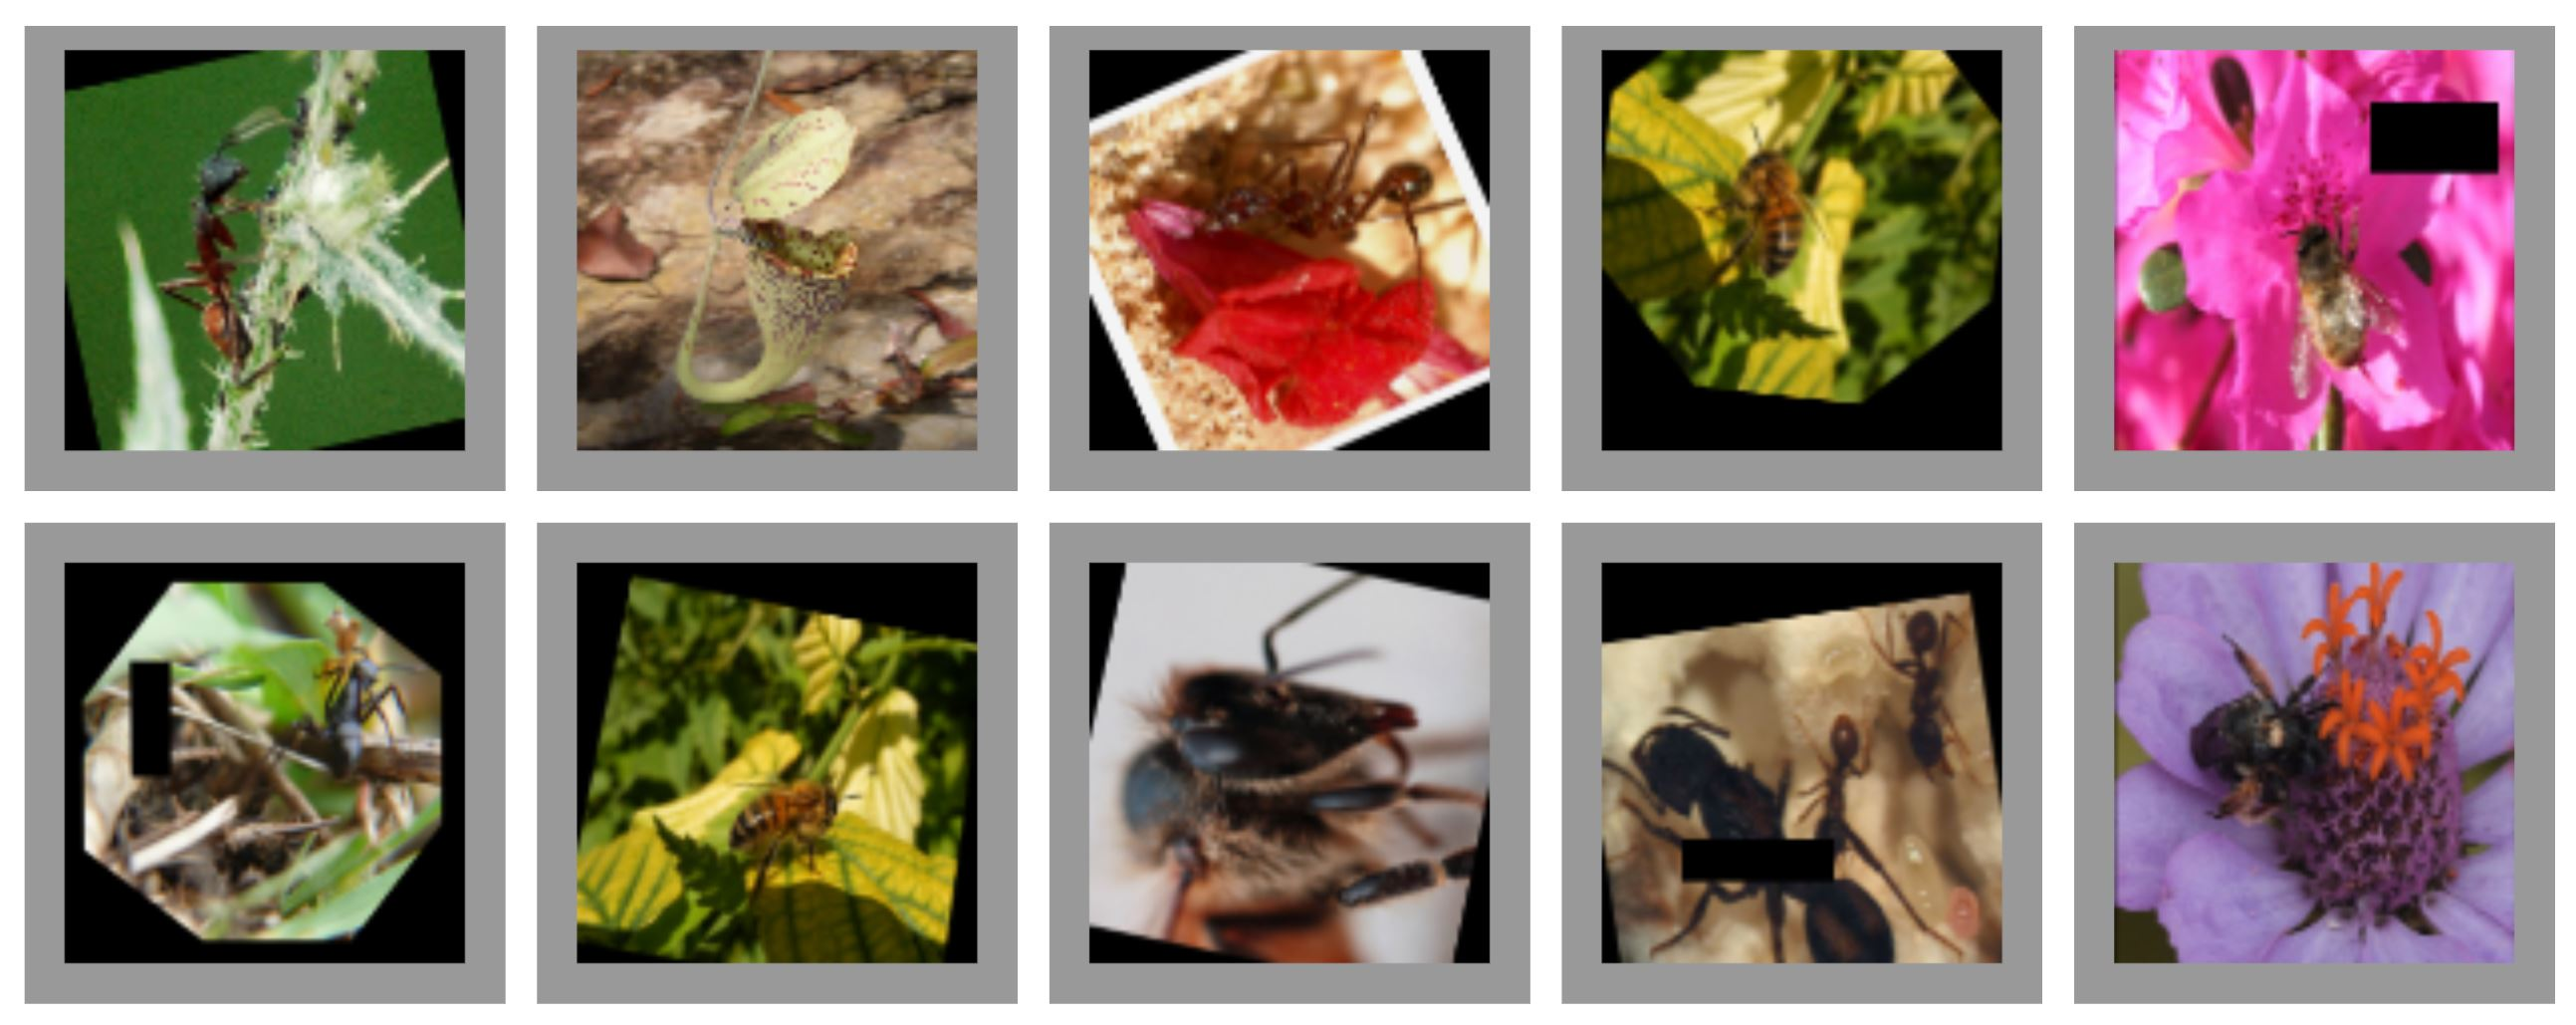


Because MuAugment continually picks the hardest augmented images to feed into training, the stability of training might seem wonky if graphed out. Below, the graph visualizes the validation F1 score of several training runs of a ResNet50 with arbitrarily chosen (not tuned) hyperparameters on the Kaggle Plant Disease dataset. MuAugment nevertheless outperforms competing augmentation methods, which is all we care about.

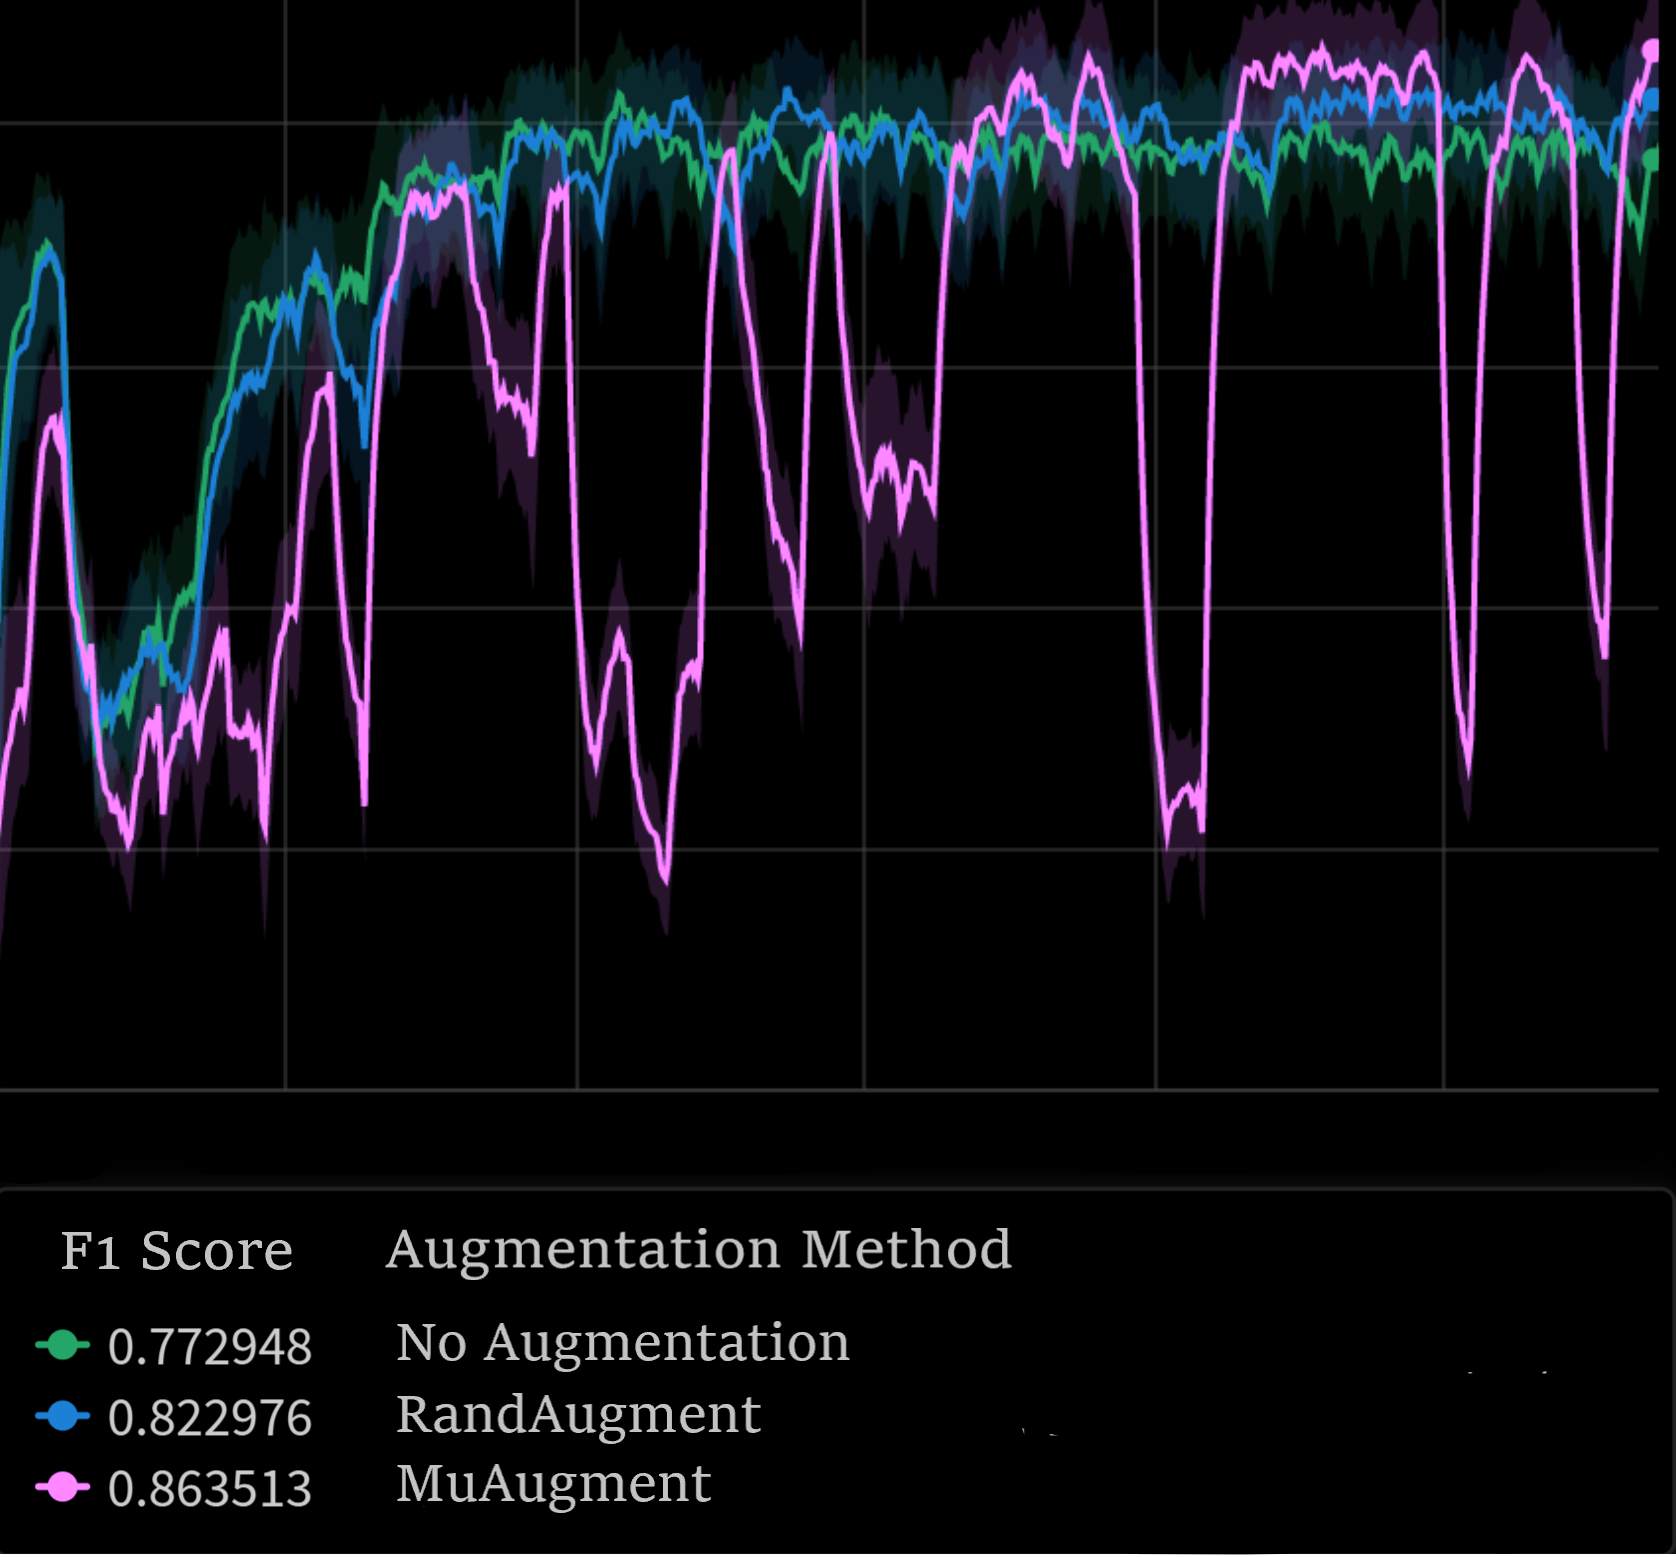


NOTE: Even though MuAugment's validation F1 score is more volatile throughout training, its training loss and training F1 score are monotonically improving.


####You've made it to the end! I hope `MuAugment`  expanded your repertoire of techniques for improving neural network training in classification tasks. ✨🐱‍🐉✨